In [1]:
import pandas as pd
import geopandas as gpd
import numpy as np
import matplotlib.pyplot as plt
from shapely import geometry
from osgeo import gdal

In [2]:
ref=gdal.Open('/mnt/g/TOPSOIL/Clay_eu23.tif')
data=pd.read_excel('/mnt/g/TOPSOIL/LUCAS_TOPSOIL_v1.xlsx')
data=data.dropna(subset=['GPS_LONG', 'GPS_LAT'])
cmap = 'Spectral_r'

In [3]:
data['geometry']=[geometry.Point(x, y) for x, y in zip(data['GPS_LONG'], data['GPS_LAT'])]
data = gpd.GeoDataFrame(data, geometry='geometry', crs= 'EPSG:4326')
data.head()

,POINT_ID,coarse,clay,silt,sand,pH_in_H2O,pH_in_CaCl2,OC,CaCO3,N,P,K,CEC,Notes,sample_ID,GPS_LAT,GPS_LONG,geometry
0,NE,25,17,39,43,7.98,7.37,21.5,776.0,1.7,182.0,571.0,14.7,NaN,31035,34.68497,32.69123,POINT (32.69123 34.68497)
1,NE,28,25,41,34,8.26,7.54,26.7,611.0,1.6,5.0,148.0,23.4,NaN,31044,34.68909,32.89669,POINT (32.89669 34.68909)
2,NE,19,30,48,22,8.22,7.48,28.5,588.0,2.7,5.0,249.0,28.2,NaN,31034,34.69027,32.67023,POINT (32.67023 34.69027)
3,NE,20,23,50,27,8.34,7.47,19.6,655.0,1.1,5.0,299.0,18.2,NaN,31036,34.70906,32.74421,POINT (32.74421 34.70906)
4,NE,17,29,39,32,8.06,7.46,18.3,499.0,1.3,15.0,225.0,23.4,NaN,31021,34.71142,32.58621,POINT (32.58621 34.71142)


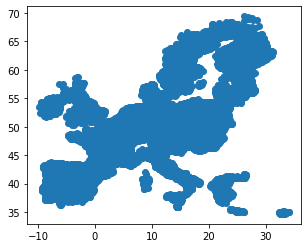

In [4]:
data.plot()

In [5]:
data= data.to_crs(ref.GetProjectionRef())
data['xproj']=[d.x for d in data.geometry]
data['yproj']=[d.y for d in data.geometry]

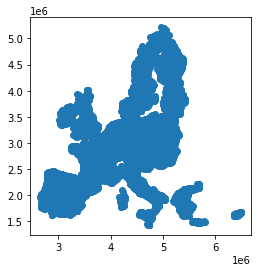

In [6]:
data.plot()

In [7]:
data.head()

,POINT_ID,coarse,clay,silt,sand,pH_in_H2O,pH_in_CaCl2,OC,CaCO3,N,P,K,CEC,Notes,sample_ID,GPS_LAT,GPS_LONG,geometry,xproj,yproj
0,NE,25,17,39,43,7.98,7.37,21.5,776.0,1.7,182.0,571.0,14.7,NaN,31035,34.68497,32.69123,POINT (6390000.367 1600000.006),6.390000e+06,1.600000e+06
1,NE,28,25,41,34,8.26,7.54,26.7,611.0,1.6,5.0,148.0,23.4,NaN,31044,34.68909,32.89669,POINT (6408000.048 1606000.231),6.408000e+06,1.606000e+06
2,NE,19,30,48,22,8.22,7.48,28.5,588.0,2.7,5.0,249.0,28.2,NaN,31034,34.69027,32.67023,POINT (6388000.122 1600000.082),6.388000e+06,1.600000e+06
3,NE,20,23,50,27,8.34,7.47,19.6,655.0,1.1,5.0,299.0,18.2,NaN,31036,34.70906,32.74421,POINT (6393999.615 1603999.773),6.394000e+06,1.604000e+06
4,NE,17,29,39,32,8.06,7.46,18.3,499.0,1.3,15.0,225.0,23.4,NaN,31021,34.71142,32.58621,POINT (6379999.629 1600000.290),6.380000e+06,1.600000e+06


In [8]:
pixel_size = 500
x_range = np.arange(data.xproj.min()-data.xproj.min() % pixel_size,
                    data.xproj.max(), pixel_size)
y_range = np.arange(data.yproj.min()-data.yproj.min() % pixel_size,
                    data.yproj.max(), pixel_size)[::-1]

In [9]:
resdata=data['clay']

In [10]:
vmin = 0
vmax = 100

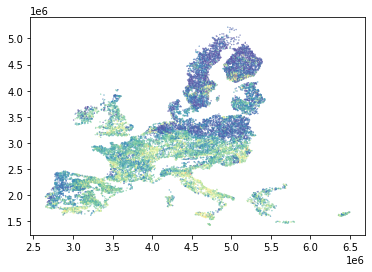

In [11]:
plt.scatter(data.xproj, data.yproj, cmap=cmap, s=0.1, c=resdata, vmin=vmin, vmax=vmax)

In [12]:
shape = (len(y_range), len(x_range))

In [13]:
extent = xmin, xmax, ymin, ymax = x_range.min(), x_range.max(), y_range.min(), y_range.max()

In [14]:
x_mesh, y_mesh = np.meshgrid(x_range, y_range)

In [15]:
data.loc[:, 'X_INDEX'] = np.floor(((data.xproj - xmin) / pixel_size)).astype(int)
data.loc[:, 'Y_INDEX'] = np.floor(shape[0] - ((data.yproj - ymin) / pixel_size)).astype(int)
data_array = np.zeros(shape)
data_array[:] = np.nan
data_array[data.Y_INDEX, data.X_INDEX] = resdata


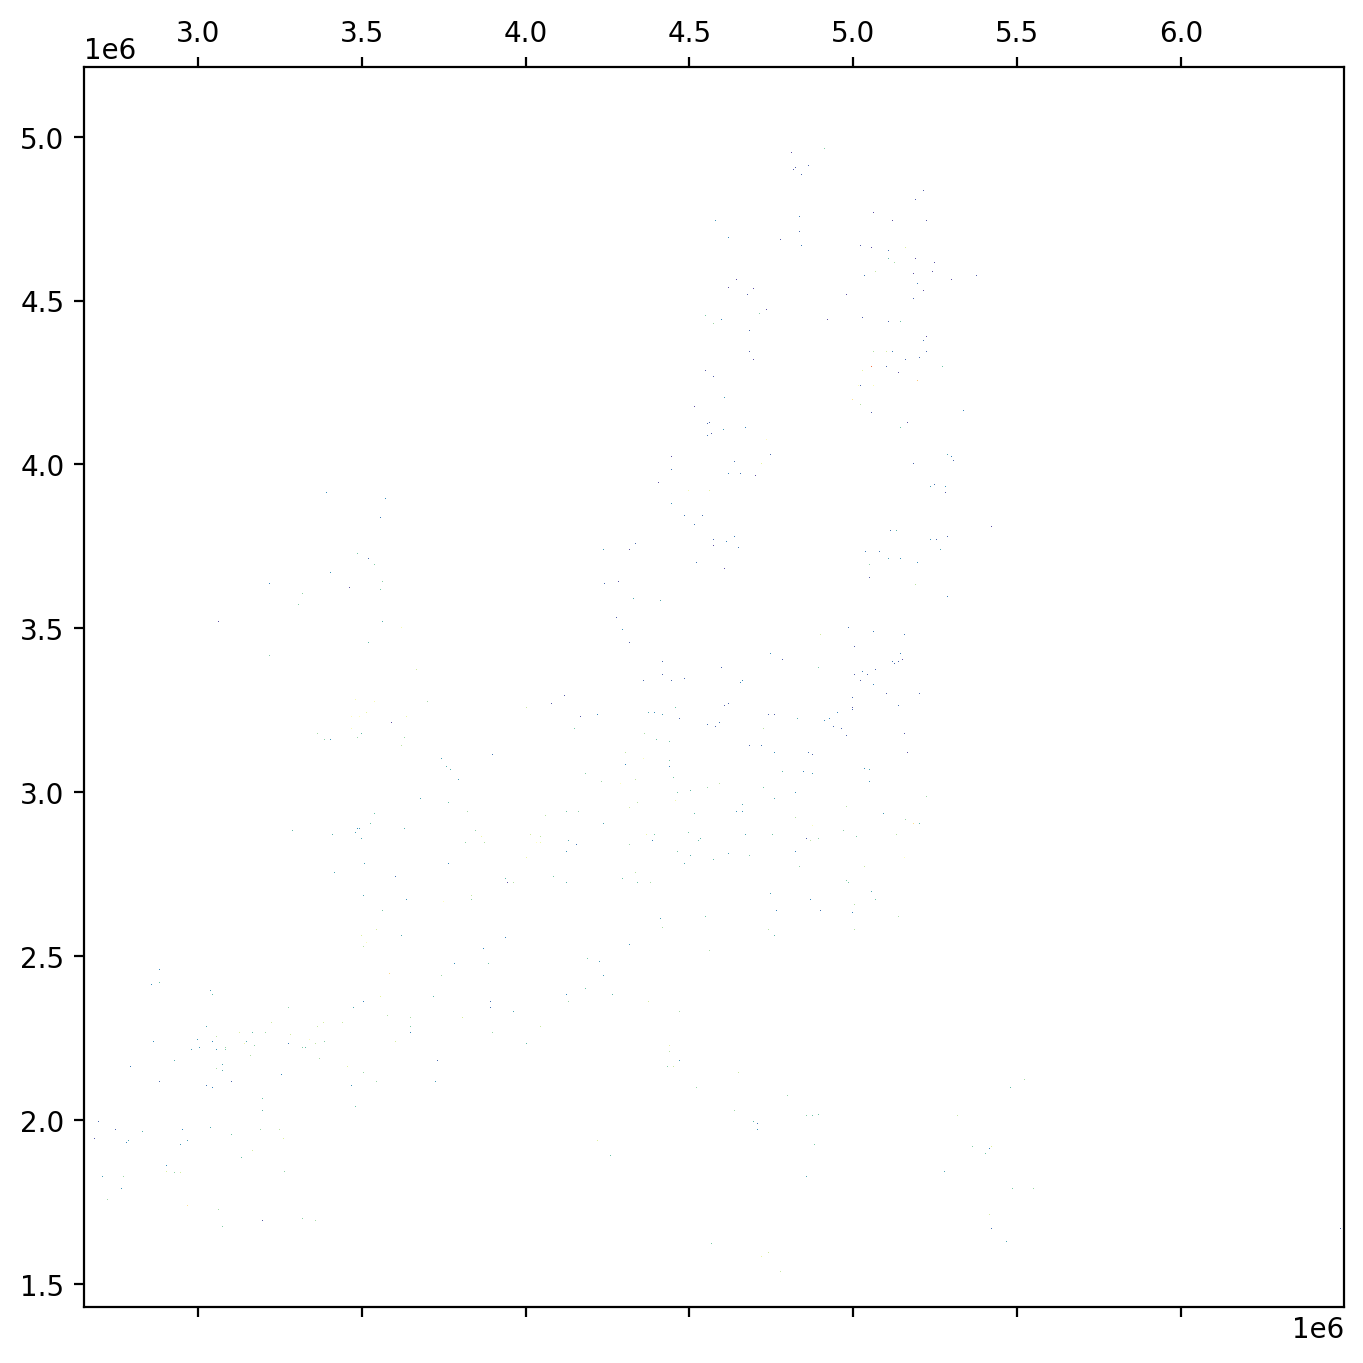

In [16]:
plt.matshow(data_array, cmap=cmap, vmin=vmin, vmax=vmax, extent=extent)
plt.gcf().set_size_inches(12, 8)
plt.gcf().set_dpi(200)

In [17]:
from sklearn.ensemble import RandomForestRegressor, ExtraTreesRegressor, GradientBoostingRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.preprocessing import MinMaxScaler

In [18]:
regrs = [KNeighborsRegressor(),
        GradientBoostingRegressor(),
        ExtraTreesRegressor(),
        RandomForestRegressor()
       ]

y_fit = data_array[np.isfinite(data_array)]
x_index_fit, y_index_fit = np.where(np.isfinite(data_array))
x_index_pred, y_index_pred = np.where(data_array)

X_fit = MinMaxScaler().fit_transform(np.vstack([x_index_fit, y_index_fit]).T)
X_pred = MinMaxScaler().fit_transform(np.vstack([x_index_pred, y_index_pred]).T)



/usr/local/lib/python3.6/dist-packages/sklearn_contrib_py_earth-0.1.0-py3.6-linux-x86_64.egg/pyearth/earth.py:802: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  pruning_passer.run()
/usr/local/lib/python3.6/dist-packages/sklearn_contrib_py_earth-0.1.0-py3.6-linux-x86_64.egg/pyearth/earth.py:1055: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  coef, resid = np.linalg.lstsq(B, weighted_y[:, i])[0:2]


Text(0.5, 1.15, 'Earth')

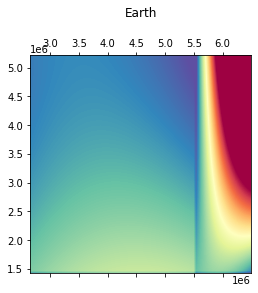

In [22]:
from pyearth import Earth
fig=plt.figure()
ax=fig.gca()
regr=Earth(max_degree=2)
regr.fit(X=X_fit, y=y_fit)
y_pred = regr.predict(X=X_pred)
Y_pred_reshaped = np.zeros(shape)
Y_pred_reshaped[:] = np.nan
for i,_ in enumerate(y_pred):
    Y_pred_reshaped[x_index_pred[i],y_index_pred[i]]=y_pred[i]

ax.matshow(Y_pred_reshaped, extent=extent, cmap=cmap, vmin=vmin, vmax=vmax)
#    ax.matshow(y_pred.reshape(shape), extent=extent, cmap=cmap, vmin=vmin, vmax=vmax)
ax.set_title('Earth', y=1.15)

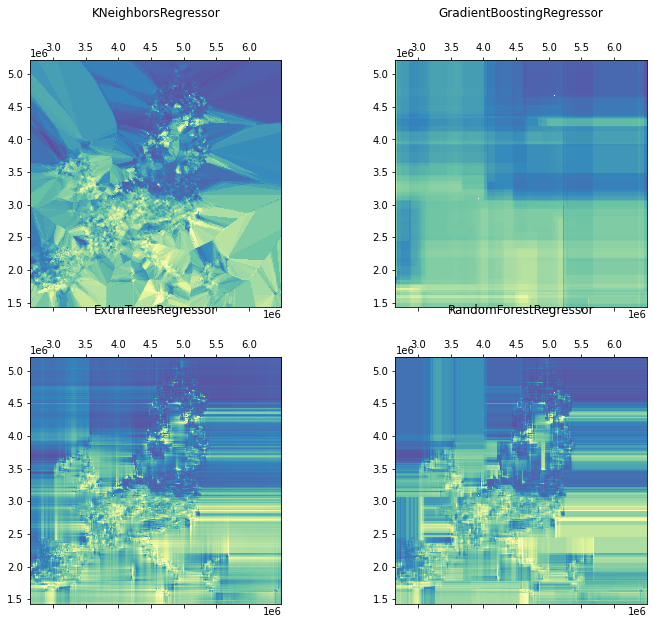

In [19]:
fig, axes = plt.subplots(2, 2, figsize=(12,10))
for ax, regr, title in zip(axes.ravel(),
                          regrs,
                          ['KNeighborsRegressor', 
                           'GradientBoostingRegressor', 
                           'ExtraTreesRegressor', 
                           'RandomForestRegressor']):

    regr.fit(X=X_fit, y=y_fit)
    y_pred = regr.predict(X=X_pred)
    Y_pred_reshaped = np.zeros(shape)
    Y_pred_reshaped[:] = np.nan
    for i,_ in enumerate(y_pred):
        Y_pred_reshaped[x_index_pred[i],y_index_pred[i]]=y_pred[i]

    ax.matshow(Y_pred_reshaped, extent=extent, cmap=cmap, vmin=vmin, vmax=vmax)
#    ax.matshow(y_pred.reshape(shape), extent=extent, cmap=cmap, vmin=vmin, vmax=vmax)
    ax.set_title(title, y=1.15)

In [20]:
import autosklearn.classification
import sklearn.model_selection
import sklearn.datasets
import sklearn.metrics

/home/geoffreybess/.local/lib/python3.6/site-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.metrics.classification module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.metrics. Anything that cannot be imported from sklearn.metrics is now part of the private API.
  warnings.warn(message, FutureWarning)


In [21]:
import tpot

In [22]:
tregr = tpot.TPOTRegressor(n_jobs=7, verbosity=2, generations=5, warm_start=True)
tregr.fit(X_fit, y_fit)

Generation 1 - Current best internal CV score: -128.6790044836287
Generation 2 - Current best internal CV score: -128.6790044836287
Generation 3 - Current best internal CV score: -128.6790044836287
Generation 4 - Current best internal CV score: -128.31939192558508
Generation 5 - Current best internal CV score: -128.31939192558508

Best pipeline: ExtraTreesRegressor(RBFSampler(input_matrix, gamma=0.8500000000000001), bootstrap=True, max_features=0.45, min_samples_leaf=13, min_samples_split=6, n_estimators=100)


TPOTRegressor(config_dict=None, crossover_rate=0.1, cv=5,
              disable_update_check=False, early_stop=None, generations=5,
              max_eval_time_mins=5, max_time_mins=None, memory=None,
              mutation_rate=0.9, n_jobs=7, offspring_size=None,
              periodic_checkpoint_folder=None, population_size=100,
              random_state=None, scoring=None, subsample=1.0, template=None,
              use_dask=False, verbosity=2, warm_start=True)

In [23]:
tpot_pred = tregr.predict(X_pred)

MemoryError: Unable to allocate 21.7 GiB for an array with shape (58219618, 100) and data type float32

In [ ]:
mag_TPOT = tpot_pred.reshape(shape)

In [ ]:
tregr.export('models/spatial_interpolator.py')

In [ ]:
fig = plt.figure(figsize=(15, 10))
ax = fig.add_subplot(111)
ax.matshow(mag_TPOT, extent=extent, cmap=cmap, vmin=vmin, vmax=vmax)
ax.scatter(data.xproj[::25], mag_data.yproj[::25], 
           cmap=cmap, s=40, c=resdata[::25], vmin=vmin, vmax=vmax, linewidths=1, edgecolors='k')
